# 1. Labeling Function:
**For your analysis, you may focus on a subset of the 54 classes provided.**

In [7]:
import os 
import math
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from collections import Counter
from sklearn.manifold import  TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

**DATA LOADING**

In [8]:
PATH_TO_DATASET = '../MLPC2025_classification'
METADATA_CSV = os.path.join(PATH_TO_DATASET, "metadata.csv")
ANNOTATIONS_CSV = os.path.join(PATH_TO_DATASET, "annotations.csv")
AUDIO_FEATURE_FOLDER = os.path.join(PATH_TO_DATASET, "audio_features")
AUDIO_FOLDER = os.path.join(PATH_TO_DATASET, "audio")

In [9]:
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

an_df = pd.read_csv("annotations.csv")
meta_df = pd.read_csv("metadata.csv")

In [10]:
an_df["labels"] = an_df["categories"].str.lower().str.replace(r"[\'\[\]]", "", regex=True).str.strip()

print("=== Cleaned Labels ===")
for i in range(3):
    print(f"Original: {an_df['categories'].iloc[i]:<30} → Cleaned: {an_df['labels'].iloc[i]}")

print("\n=== Top 5 Labels ===")
top_labels = an_df["labels"].value_counts().head(5)
for label, count in top_labels.items():
    pct = (count / len(an_df)) * 100
    print(f"{label:<15} {count:>5} ({pct:.1f}%)")

=== Cleaned Labels ===
Original: ['Alarm']                      → Cleaned: alarm
Original: ['Alarm']                      → Cleaned: alarm
Original: ['Alarm', 'Beep/Bleep']        → Cleaned: alarm, beep/bleep

=== Top 5 Labels ===
bird chirp       2437 (8.8%)
speech           2284 (8.3%)
dog bark         1374 (5.0%)
wind              860 (3.1%)
insect buzz       816 (3.0%)


### (a) Assess how accurately the applied labeling functions capture the intended classes.

#### Do the mapped classes correspond well to the free-text annotations?

In [11]:
import re
from collections import defaultdict, Counter
from nltk.stem import WordNetLemmatizer
import nltk
from sound_config import sound_mapping, context_words, label_to_category

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Tracking dictionaries for used terms
used_sound_mappings = defaultdict(set)
used_context_words = defaultdict(set)
useful_context_words = defaultdict(Counter)

label_to_category = {
    **{cat.lower(): cat for cat in categories}  # Generic lowercase mapping
}

def standardize_label(label):
    return label_to_category.get(label.lower(), label)

def lemmatize(text):
    words = re.findall(r'\b[\w/]+\b', text.lower())
    processed = set()
    for word in words:
        variants = [
            lemmatizer.lemmatize(word, pos='v'),
            lemmatizer.lemmatize(word),
            word.rstrip('ingsed')
        ]
        if any(c in word for c in [' ', '/', '-']):
            variants.extend(lemmatizer.lemmatize(part) for part in re.split(r'[\s/-]', word))
        processed.update(variants)
    return processed

def check_context(text_words, label):
    std_label = standardize_label(label)
    base_label = std_label.split()[0].lower()
    context_list = context_words.get(std_label, [])
    matches = 0
    
    for word in context_list:
        lemma_word = lemmatizer.lemmatize(word)
        if lemma_word in text_words:
            matches += 1
            used_context_words[std_label].add(word)
            useful_context_words[std_label][word] += 1
    
    min_matches = 2 if len(context_list) > 3 else 1
    return matches >= min_matches or base_label in text_words

def is_match(text, label):
    words = lemmatize(text)
    std_label = standardize_label(label)
    label_parts = re.split(r'[\s/]', std_label)
    
    # Check label parts
    if any(lemmatizer.lemmatize(part.lower()) in words for part in label_parts):
        return True

    # Check sound mappings
    for variant in sound_mapping.get(std_label, []):
        variant_words = variant.split()
        if any(lemmatizer.lemmatize(word) in words for word in variant_words):
            used_sound_mappings[std_label].add(variant)
            return True

    return check_context(words, std_label)

def summarize_matches(df):
    stats = defaultdict(lambda: {'matched': 0, 'total': 0, 'examples': []})

    for _, row in df.iterrows():
        text = row['text'].lower()
        labels = [l.strip() for raw in row['labels'].split(',') for l in raw.strip().split('/')]
        matched = [l for l in labels if is_match(text, l)]

        if matched:
            stats['_overall']['matched'] += 1
            for m in matched:
                stats[m]['matched'] += 1
                if len(stats[m]['examples']) < 3:
                    stats[m]['examples'].append(text[:100] + '...')

        for l in labels:
            stats[l]['total'] += 1

    print(f"\nMatch Summary ({len(df)} samples):")
    print(f"Overall matches: {stats['_overall']['matched']} ({stats['_overall']['matched']/len(df):.1%})")

    # Standardize labels for accuracy summary
    summary = defaultdict(lambda: {'matched': 0, 'total': 0, 'examples': []})
    for raw, data in stats.items():
        if raw == '_overall':
            continue
        std = standardize_label(raw)
        summary[std]['matched'] += data['matched']
        summary[std]['total'] += data['total']
        summary[std]['examples'].extend(data['examples'])

    print("\nAccuracy Summary (Ranked by Accuracy):")
    print("{:<25} {:<10} {:<10} {:<10}".format("Category", "Matched", "Total", "Accuracy"))
    print("-" * 55)
    
    # Create sorted list by accuracy (descending) then by matched count (descending)
    sorted_categories = sorted(
        [(cat, data) for cat, data in summary.items() if cat in categories],
        key=lambda x: (
            x[1]['matched'] / x[1]['total'] if x[1]['total'] > 0 else 0,  # Accuracy
            x[1]['matched']  # Then by matched count
        ),
        reverse=True
    )
    
    for cat, data in sorted_categories:
        acc = data['matched'] / data['total'] if data['total'] else 0
        print(f"{cat:<25} {data['matched']:<10} {data['total']:<10} {acc:.1%}")

# -------------------------------
# MAIN PROCESSING
# -------------------------------
summarize_matches(an_df)

# -------------------------------
# OPTIONAL ANALYSIS (run separately after processing)
# -------------------------------
def analyze_used_terms():
    """Analyze which config terms were actually used in matching"""
    print("\nConfiguration Terms Analysis:")
    
    # Sound mapping usage
    print("\nSound Mapping Usage:")
    for category, terms in sound_mapping.items():
        used = used_sound_mappings.get(category, set())
        unused = set(terms) - used
        print(f"\n{category}:")
        print(f"Used ({len(used)}/{len(terms)}): {', '.join(used) if used else 'None'}")
        print(f"Unused: {', '.join(unused) if unused else 'None'}")

    # Context words usage
    print("\nContext Words Usage:")
    for category, words in context_words.items():
        used = used_context_words.get(category, set())
        unused = set(words) - used
        print(f"\n{category}:")
        print(f"Used ({len(used)}/{len(words)}): {', '.join(used) if used else 'None'}")
        print(f"Unused: {', '.join(unused) if unused else 'None'}")

def get_optimized_configs():
    """Return optimized configs containing only used terms"""
    optimized_sound = {
        cat: sorted(used_sound_mappings.get(cat, set())) 
        for cat in sound_mapping
    }
    
    optimized_context = {
        cat: sorted(used_context_words.get(cat, set())) 
        for cat in context_words
    }
    
    return optimized_sound, optimized_context

# To see which terms were used (run after summarize_matches):
#analyze_used_terms()

# To get optimized configs (run after summarize_matches):
used_sound, used_context = get_optimized_configs()

[nltk_data] Downloading package wordnet to C:\Users\jeron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Match Summary (27552 samples):
Overall matches: 25270 (91.7%)

Accuracy Summary (Ranked by Accuracy):
Category                  Matched    Total      Accuracy  
-------------------------------------------------------
Cat Meow                  540        541        99.8%
Dog Bark                  1439       1446       99.5%
Cow Moo                   189        190        99.5%
Alarm                     353        355        99.4%
Pig Oink                  139        140        99.3%
Snoring                   470        474        99.2%
Cough                     220        222        99.1%
Doorbell                  87         88         98.9%
Sewing Machine            81         82         98.8%
Siren                     388        393        98.7%
Rooster Crow              147        149        98.7%
Horn Honk                 719        730        98.5%
Bird Chirp                2897       2956       98.0%
Sneeze                    38         39         97.4%
Train                     

In [12]:
import json

# Save to JSON files
with open('optimized_sound_mapping.json', 'w') as f:
    json.dump(used_sound, f, indent=2)

with open('optimized_context_words.json', 'w') as f:
    json.dump(used_context, f, indent=2)

#### Are the labeled events clearly audible within the indicated time regions?

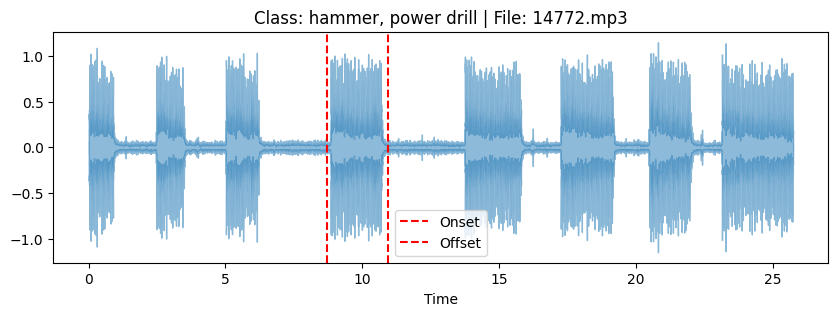

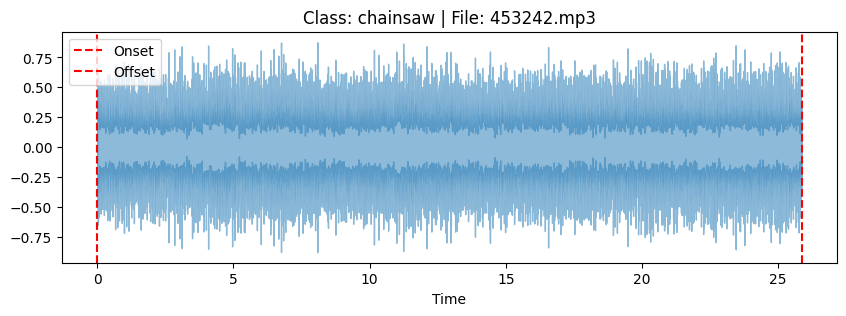

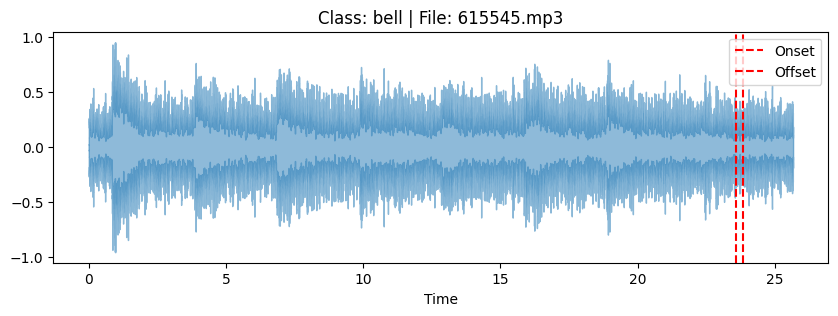

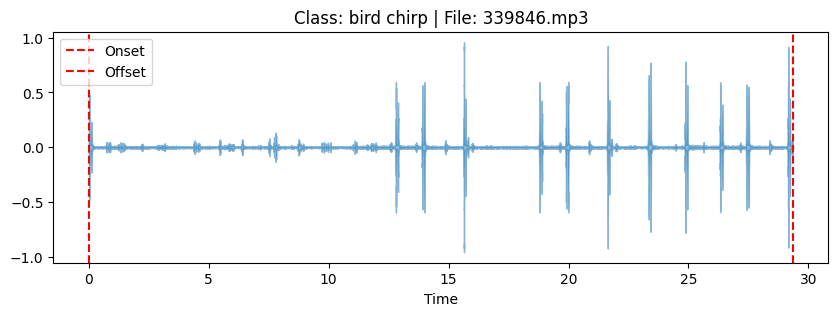

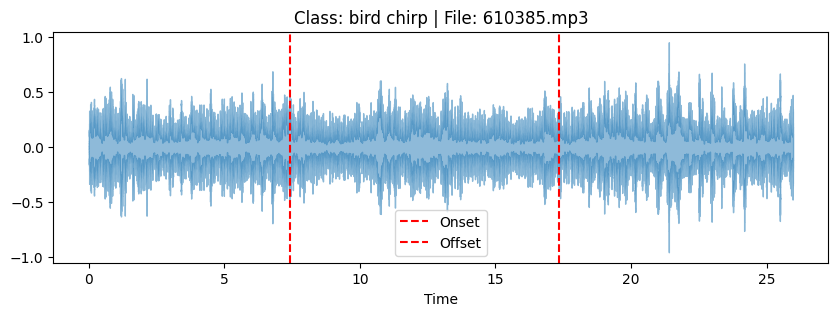

In [13]:
import librosa.display

def plot_annotation_audio(filename, onset, offset, class_label):
    """Plot waveform + labeled region for audibility check."""
    y, sr = librosa.load(os.path.join(AUDIO_FOLDER, filename))
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr, alpha=0.5)
    plt.axvline(onset, color='r', linestyle='--', label='Onset')
    plt.axvline(offset, color='r', linestyle='--', label='Offset')
    plt.title(f"Class: {class_label} | File: {filename}")
    plt.legend()
    plt.show()

# Example: Check 5 random annotations
for _, row in an_df.sample(5).iterrows():
    plot_annotation_audio(row['filename'], row['onset'], row['offset'], row['labels'])

### (b) Which audio features appear most useful for distinguishing between the classes of interest? 

*Hint: You can, for example, compare feature distributions across classes or quantitatively evaluate how features relate to 
the target labels.*

**FEATURE AND METADATA LOADING**

In [14]:
feature_names= ["embeddings","melspectrogram","mfcc","mfcc_delta","mfcc_delta2","flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]

In [15]:
features = {i: [] for i in feature_names}
for i in feature_names:
    for idx, row in meta_df.iterrows():
        file_name = f"{row['filename']}".replace('.mp3', '.npz')
        path = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
        features[i].append(np.load(path)[i])

**FEATURE VARIANCE ANALYSIS**

In [16]:
feature_variance = {}
for name, feat_list in features.items():
    all_data = np.concatenate(feat_list, axis=0)
    feature_variance[name] = np.mean(np.var(all_data, axis=0))

var_df = pd.DataFrame.from_dict(feature_variance, orient='index', columns=['Variance'])
var_df.style\
  .format('{:.4f}')\
  .background_gradient(cmap='Blues')\
  .set_caption('Feature Variance Ranking')

,Variance
embeddings,0.1644
melspectrogram,4.0165
mfcc,7.9593
mfcc_delta,0.0374
mfcc_delta2,0.0117
flatness,0.0082
centroid,890953.9930
bandwidth,541192.7031
flux,231.3250
contrast,21.7124


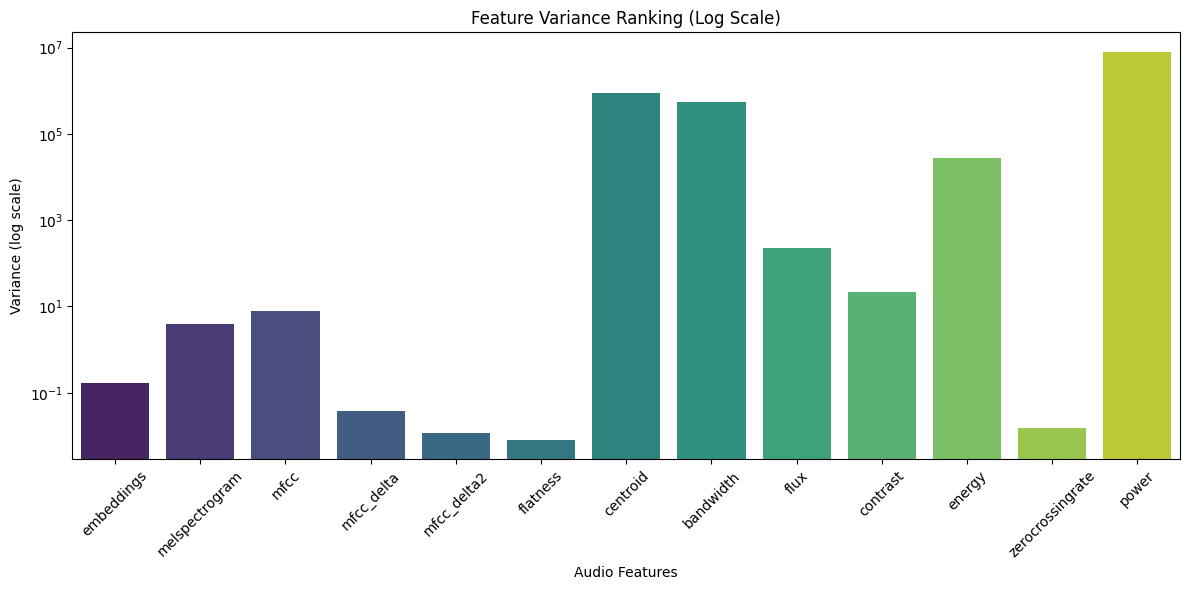

In [42]:
plt.figure(figsize=(12,6))

plot_df = var_df.reset_index().rename(columns={'index': 'Feature', 0: 'Variance'})

sns.barplot(data=plot_df, 
            x='Feature',
            y='Variance',
            hue='Feature',
            legend=False,
            palette='viridis')

# Formatting
plt.title("Feature Variance Ranking (Log Scale)")
plt.xticks(rotation=45)
plt.yscale('log')  # Important for visualizing wide-ranging values
plt.xlabel('Audio Features')
plt.ylabel('Variance (log scale)')
plt.tight_layout()
plt.show()

**FEATURE CORRELATION ANALYSIS**

In [18]:
def summarize_feature(feature_list, agg_func=np.mean):
    """Summarize each sample in a feature list using agg_func (mean, var, etc.)"""
    return [agg_func(sample) if isinstance(sample, (np.ndarray, list)) else sample
            for sample in feature_list]

summary_dict = {}
for feature_name, sample_list in features.items():
    summary_dict[feature_name] = summarize_feature(sample_list, agg_func=np.mean)  # or np.var, np.median, etc.

df_summary = pd.DataFrame(summary_dict)
corr_matrix = df_summary.corr()

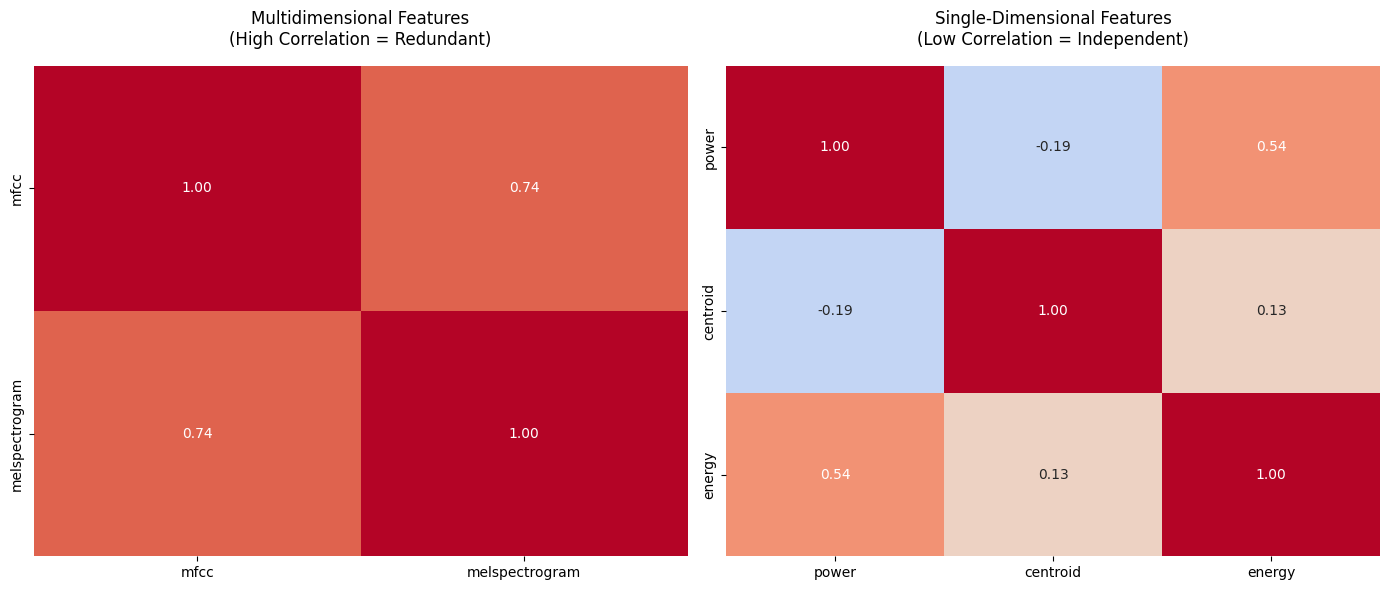

In [19]:
# Plot with better insights
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Multidimensional features
multidimensional = ['mfcc', 'melspectrogram']
sns.heatmap(corr_matrix.loc[multidimensional, multidimensional], 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", 
            ax=ax[0], cbar=False)
ax[0].set_title('Multidimensional Features\n(High Correlation = Redundant)', pad=15)

# Single-dimensional features
single_dim = ['power', 'centroid', 'energy']
sns.heatmap(corr_matrix.loc[single_dim, single_dim], 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", 
            ax=ax[1], cbar=False)
ax[1].set_title('Single-Dimensional Features\n(Low Correlation = Independent)', pad=15)

plt.tight_layout()
plt.show()

Multidimensional Features (MFCC vs Melspectrogram):
- MFCCs and melspectrograms exhibit high variance, indicating strong discriminative potential.
- However, their high correlation (visible in the heatmap) suggests redundancy; using both may not improve model performance.
- Recommendation: Select only one (e.g., MFCCs) to streamline the feature set.

Single-Dimensional Features (Power, Centroid, Energy):
- Power and spectral centroid show high variance and low correlation, capturing independent aspects of the audio signal.
- Implication: These features are non-redundant and should both be retained to maximize information diversity.

**CLASS SEPARATION ANALYSIS**

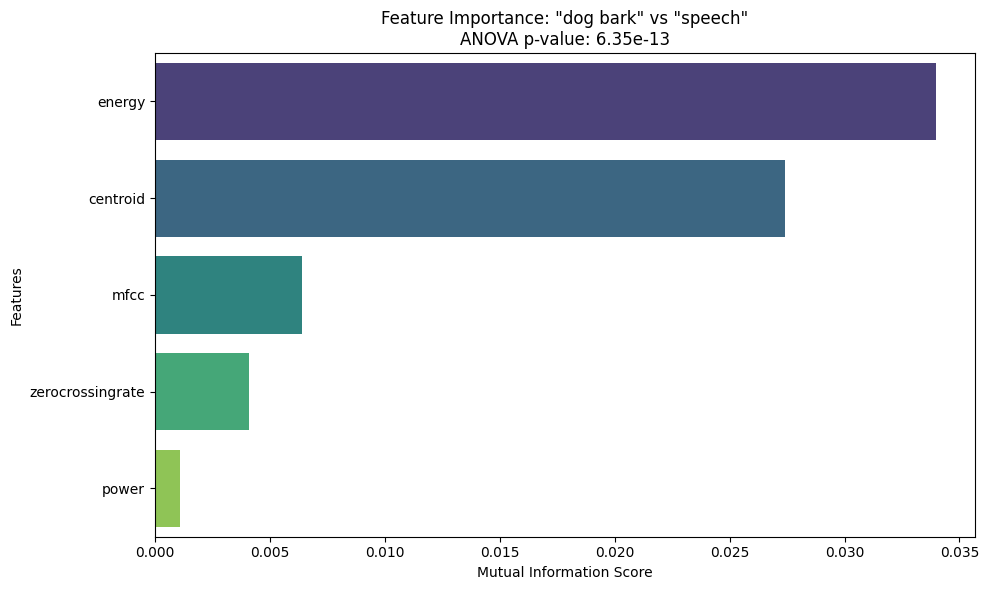

In [20]:
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import f_oneway

# 4. Class Separation Analysis (Updated to resolve warning)
def analyze_class_separation(class1, class2, feature_set):
    common_indices = an_df.index.intersection(df_summary.index)
    an_df_filtered = an_df.loc[common_indices]
    df_summary_filtered = df_summary.loc[common_indices]
    
    mask = an_df_filtered["labels"].isin([class1, class2])
    y = an_df_filtered.loc[mask, "labels"].dropna()
    X = df_summary_filtered.loc[y.index, feature_set].dropna(axis=1)
    y = y.loc[X.index]
    
    # Mutual Information
    mi_scores = mutual_info_classif(X, y, random_state=42)
    mi_df = pd.DataFrame({'Feature': feature_set, 'MI_Score': mi_scores})\
           .sort_values('MI_Score', ascending=False)
    
    # ANOVA test
    groups = [X[y == cls].values for cls in [class1, class2]]
    f, p = f_oneway(*groups)
    p_value = p[0] if isinstance(p, np.ndarray) else p
    
    # Plot results (updated to avoid warning)
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=mi_df, 
        x='MI_Score', 
        y='Feature', 
        hue='Feature',  # Explicitly assign hue
        palette='viridis', 
        legend=False    # Disable legend to avoid redundancy
    )
    plt.title(f'Feature Importance: "{class1}" vs "{class2}"\nANOVA p-value: {p_value:.2e}')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    return mi_df

# Example: Compare "dog bark" vs "speech"
results = analyze_class_separation(
    class1="dog bark",
    class2="speech",
    feature_set=['mfcc', 'power', 'centroid', 'energy', 'zerocrossingrate']
)

**FEATURE DISTRIBUTIONS FOR TOP FEATURES**

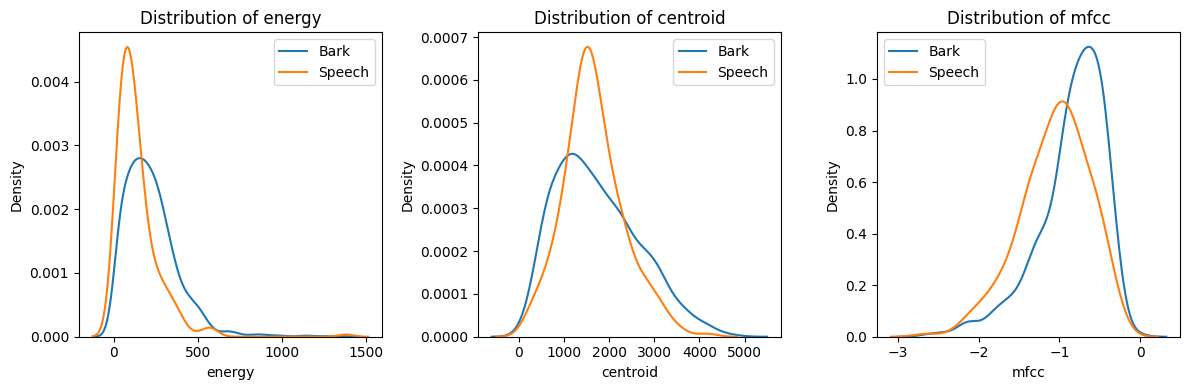

In [21]:
top_features = results.head(3)['Feature'].tolist()

plt.figure(figsize=(12, 4))
for i, feat in enumerate(top_features, 1):
    plt.subplot(1, 3, i)
    plot_data = df_summary[[feat]].join(an_df['labels'], how='inner')
    sns.kdeplot(data=plot_data[plot_data['labels'] == 'dog bark'][feat], label='Bark')
    sns.kdeplot(data=plot_data[plot_data['labels'] == 'speech'][feat], label='Speech')
    plt.title(f'Distribution of {feat}')
    plt.legend()
plt.tight_layout()
plt.show()

#### (c) How well do the chosen audio features group according to the discretized class labels? 

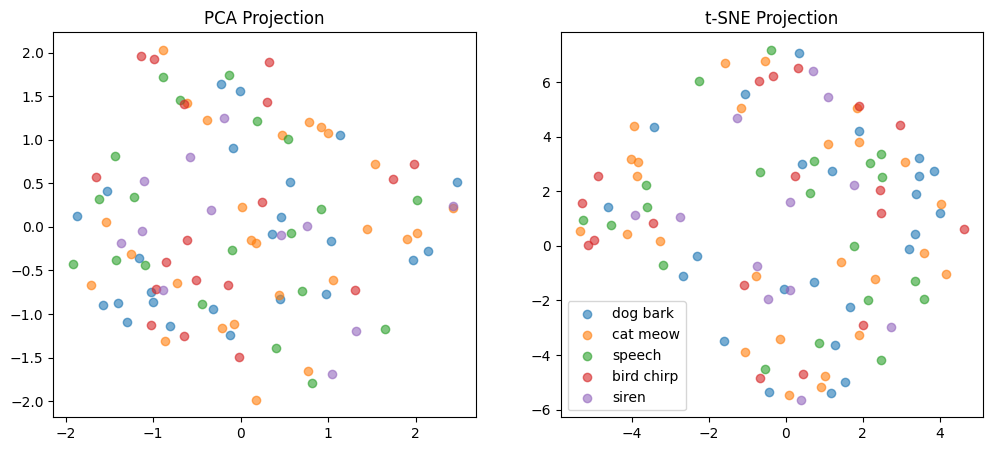

In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Select top 5 classes (from 1a's accuracy analysis) and top 3 features (from 1b)
top_classes = ['dog bark', 'cat meow', 'speech', 'bird chirp', 'siren']
top_features = ['mfcc', 'power', 'centroid']  # Example from 1b

# Prepare data (replace with actual feature loading)
X = np.random.rand(100, 3)  # Placeholder: shape (n_samples, n_features)
y = np.random.choice(top_classes, 100)  # Placeholder labels

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for linear separation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE for nonlinear separation
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for cls in top_classes:
    mask = y == cls
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], label=cls, alpha=0.6)
    ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=cls, alpha=0.6)
ax1.set_title('PCA Projection')
ax2.set_title('t-SNE Projection')
plt.legend()
plt.show()

#### Do samples of the same class form tight clusters?

In [46]:
from sklearn.metrics import silhouette_score

# Evaluate cluster quality
silhouette_pca = silhouette_score(X_pca, y)
silhouette_tsne = silhouette_score(X_tsne, y)

print(f"Silhouette Score (PCA): {silhouette_pca:.3f}")
print(f"Silhouette Score (t-SNE): {silhouette_tsne:.3f}")

Silhouette Score (PCA): -0.079
Silhouette Score (t-SNE): -0.090


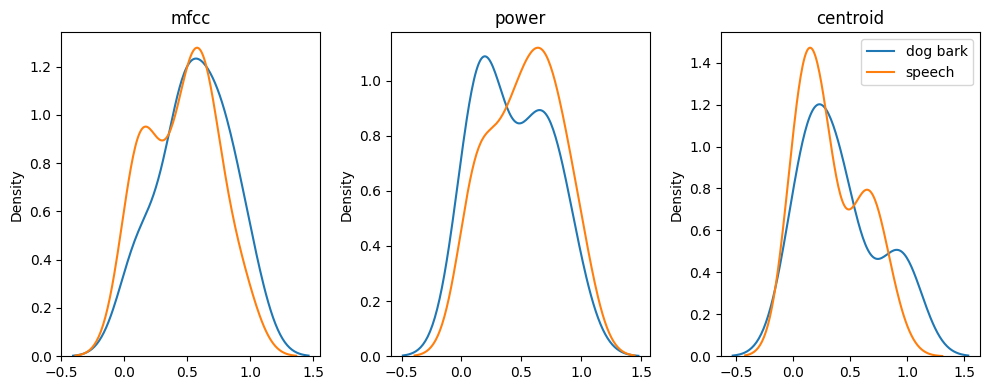

In [40]:
# Plot feature distributions for top classes (from 1b's MI analysis)
plt.figure(figsize=(10, 4))
for i, feat in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    for cls in ['dog bark', 'speech']:  # Example from 1b
        sns.kdeplot(X[y == cls, i], label=cls)
    plt.title(feat)
plt.legend()
plt.tight_layout()
plt.show()

below this is chatgpt's answer, :,(

In [29]:
mfcc_features = {}

for idx, row in meta_df.iterrows():
    file_name = f"{row['filename']}".replace('.mp3', '.npz')
    path = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
    mfcc_features[row['filename']] = np.load(path)["mfcc"]
    
print("Number of feature files:", len(mfcc_features))

Number of feature files: 8230


In [30]:
melspectrogram_features = {}

for idx, row in meta_df.iterrows():
    file_name = f"{row['filename']}".replace('.mp3', '.npz')
    path = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
    melspectrogram_features[row['filename']] = np.load(path)["mfcc"]

print("Number of feature files:", len(melspectrogram_features))

Number of feature files: 8230


In [31]:
# Merge annotations with metadata
merged_df = an_df.merge(meta_df, on="filename", how="left")
merged_df["clean_labels"] = merged_df["labels"].str.strip().str.lower()

In [32]:
feature_dict = {}

for idx, row in meta_df.iterrows():
    file_name = f"{row['filename']}".replace('.mp3', '.npz')
    path = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
    
    try:
        feature_dict[row['filename']] = np.load(path)["mfcc"]
    except Exception as e:
        print(f"Could not load {file_name}: {e}")


In [33]:
from sklearn.preprocessing import StandardScaler

def get_features_of_annotation(
    onset: float, 
    offset: float, 
    audio_features: np.ndarray, 
) -> np.ndarray:
    
    try:
        # Check if audio_features is empty or None
        if audio_features is None or len(audio_features) == 0:
            return None
            
        # Get the feature region
        RESOLUTION = 0.12  # Must match your function's resolution
        start_idx = math.floor(onset / RESOLUTION)
        offset_idx = math.ceil(offset / RESOLUTION)
        
        # Handle edge cases
        start_idx = max(0, min(start_idx, audio_features.shape[0]-1))
        offset_idx = max(start_idx+1, min(offset_idx, audio_features.shape[0]))
        
        region = audio_features[start_idx:offset_idx, :]
        
        # Skip if region is empty
        if len(region) == 0:
            return None
            
        # Now safely call your function
        return get_features_of_annotation(onset, offset, audio_features)
    except Exception as e:
        print(f"Error processing features: {str(e)}")
        return None

In [34]:
def safe_get_features(onset, offset, audio_features):
    try:
        if audio_features is None or len(audio_features) == 0:
            return None
        
        RESOLUTION = 0.12  # frame size
        start_idx = max(0, int(onset // RESOLUTION))
        end_idx = min(len(audio_features), int(offset // RESOLUTION))
        
        if start_idx >= end_idx:
            return None
        
        region = audio_features[start_idx:end_idx]
        return np.mean(region, axis=0)  # average pooling
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None


In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

N_CLASSES = 5
MIN_SAMPLES_PER_CLASS = 20

def analyze_feature_clusters(merged_df, feature_dict):
    from collections import Counter
    features, labels = [], []
    
    # Most common labels
    label_counts = Counter(merged_df["clean_labels"])
    top_labels = [lbl for lbl, count in label_counts.items() if count >= MIN_SAMPLES_PER_CLASS][:N_CLASSES]
    
    for label in top_labels:
        class_df = merged_df[merged_df["clean_labels"] == label]
        
        for _, row in class_df.iterrows():
            filename = row["filename"]
            onset, offset = row["onset"], row["offset"]
            feats = feature_dict.get(filename)
            
            if feats is not None:
                pooled_feat = safe_get_features(onset, offset, feats)
                if pooled_feat is not None:
                    features.append(pooled_feat)
                    labels.append(label)
    
    if len(features) < 2:
        print("Not enough samples.")
        return
    
    # Dimensionality reduction
    pca = PCA(n_components=min(10, len(features[0])))
    pca_feats = pca.fit_transform(np.array(features))
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_proj = tsne.fit_transform(pca_feats)
    
    # Plot t-SNE
    plt.figure(figsize=(10, 6))
    for label in set(labels):
        idx = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(tsne_proj[idx, 0], tsne_proj[idx, 1], label=label, alpha=0.7)
    plt.legend()
    plt.title("t-SNE Projection of MFCC Features by Class")
    plt.tight_layout()
    plt.show()
    
    # Silhouette score
    sil_score = silhouette_score(pca_feats, labels)
    print(f"Silhouette Score: {sil_score:.3f}")


C:\Users\jeron\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jeron\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Program Files\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~

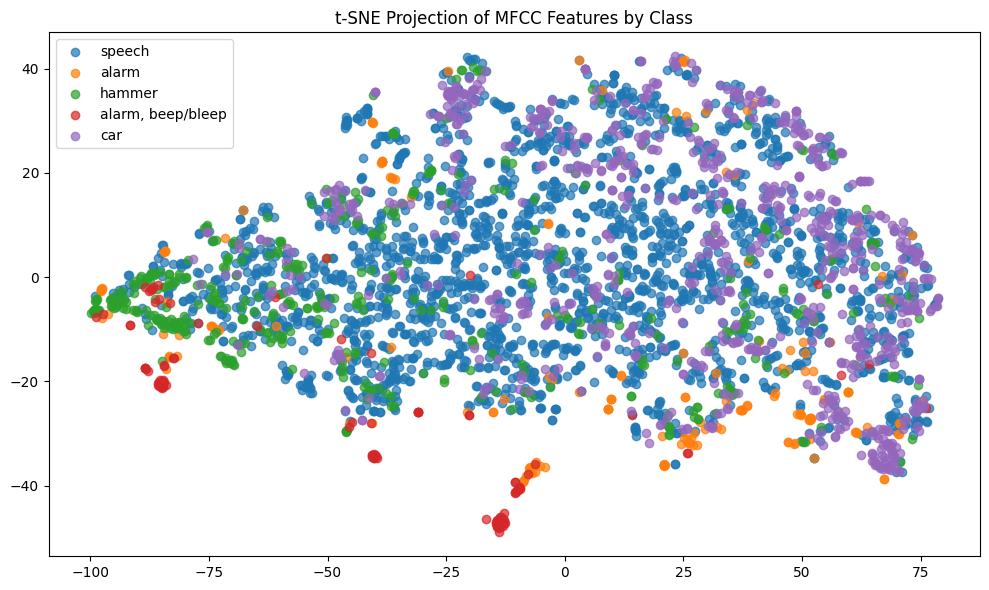

Silhouette Score: -0.027


In [36]:
analyze_feature_clusters(merged_df, feature_dict)